In [1]:
using Interpolations
using DifferentialEquations
using PyCall
using NPZ
using Statistics
using QuadGK
using Plots

In [161]:
using PyPlot
import PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


In [136]:
using LaTeXStrings

In [2]:
filepath = "/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/pixie3d.h5"

"/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/pixie3d.h5"

In [3]:
timestep = 110;
Ncons = 4; # Number of initial conditions

## Functions for divergence cleanup

In [142]:
function quad_r_int(B_eint,xmin,xmax,yo)
    res, err = quadgk(x -> B_eint(x,yo),xmin,xmax)
    return res
end

function quad_r_int(B_eint,xmin,xmax,yo,zo)
    res, err = quadgk(x -> B_eint(x,yo,zo),xmin,xmax)
    return res
end

function quad_u_int(B_eint,ymin,ymax,xo,zo)
    res, err = quadgk(y -> B_eint(xo,y,zo),ymin,ymax)
    return res
end

function quad_u_int(B_eint,ymin,ymax,xo)
    res, err = quadgk(y -> B_eint(xo,y),ymin,ymax)
    return res
end

function Au(B3_eint,ro,uo,rMA,uMA)
    A = quad_r_int(B3_eint,rMA,ro,uo)
    return A
end

function Au(B3_eint,ro,uo,rMA,uMA,zo)
    A = quad_r_int(B3_eint,rMA,ro,uo,zo)
    return A
end

function Aphi(B1_eint,B2_eint,ro,uo,rMA,uMA)
    A = quad_u_int(B1_eint,uMA,uo,ro) - quad_r_int(B2_eint,rMA,ro,uMA)
    return A
end

function Aphi(B1_eint,B2_eint,ro,uo,rMA,uMA,zo)
    A = quad_u_int(B1_eint,uMA,uo,ro,zo) - quad_r_int(B2_eint,rMA,ro,uMA,zo)
    return A
end

function grid_Au(B3_eint,Ndims::Int)
    if Ndims == 3
        Au_arr = []
        for ro in rn
            for uo in un
                for fo in phin
                    rMA = rmaxis[1]
                    uMA = umaxis[1]
                    append!(Au_arr,Au(B3_eint,ro,uo,rMA,uMA,fo))
                end
            end
        end
        Au_arr = permutedims(reshape(Au_arr, size(phin)[1], size(un)[1],size(rn)[1]),(3,2,1))
    elseif Ndims == 2
        Au_arr = []
        for ro in rn
            for uo in un
                rMA = rmaxis[1]
                uMA = umaxis[1]
                append!(Au_arr,Au(B3_eint,ro,uo,rMA,uMA))
            end
        end
        Au_arr = permutedims(reshape(Au_arr, size(un)[1],size(rn)[1]),(2,1))
    end
    return Au_arr
end

function grid_Aphi(B1_eint,B2_eint,Ndims::Int)
    if Ndims == 3
        Aphi_arr = []
        for ro in rn
            for uo in un
                for fo in phin
                    rMA = rmaxis[1]
                    uMA = umaxis[1]
                    append!(Aphi_arr,Aphi(B1_eint,B2_eint,ro,uo,rMA,uMA,fo))
                end
            end
        end
        Aphi_arr = permutedims(reshape(Aphi_arr, size(phin)[1],size(un)[1],size(rn)[1]),(3,2,1))
    elseif Ndims == 2
        Aphi_arr = []
        for ro in rn
            for uo in un
                rMA = rmaxis[1]
                uMA = umaxis[1]
                append!(Aphi_arr,Aphi(B1_eint,B2_eint,ro,uo,rMA,uMA))
            end
        end
        Aphi_arr = permutedims(reshape(Aphi_arr, size(un)[1],size(rn)[1]),(2,1))
    end
    return Aphi_arr
end

function b1_an(GAp_eint, Ndims::Int)
    if Ndims == 2
        b1_an = []
        for r in rn
            for u in un
                append!(b1_an, Interpolations.gradient(GAp_eint,r,u)[2])
            end
        end
        b1_an = permutedims(reshape(b1_an, size(un)[1],size(rn)[1]),(2,1))
    elseif Ndims == 3
        b1_an = []
        for r in rn
            for u in un
                for f in phin
                    append!(b1_an, Interpolations.gradient(GAp_eint,r,u,f)[2])
                end
            end
        end
        b1_an = permutedims(reshape(b1_an, size(phin)[1],size(un)[1],size(rn)[1]),(3,2,1))
    end
    return b1_an
end
    
function b2_an(GAp_eint,Ndims::Int)
    if Ndims == 2
        b2_an = []
        for r in rn
            for u in un
                append!(b2_an, -Interpolations.gradient(GAp_eint,r,u)[1])
            end
        end
        b2_an = permutedims(reshape(b2_an, size(un)[1],size(rn)[1]),(2,1))
    elseif Ndims == 3 
        b2_an = []
        for r in rn
            for u in un
                for f in phin
                    append!(b2_an, -Interpolations.gradient(GAp_eint,r,u,f)[1])
                end
            end
        end
        b2_an = permutedims(reshape(b2_an, size(phin)[1],size(un)[1],size(rn)[1]),(3,2,1))
    end
    return b2_an
end 

function b3_an(GAu_eint,Ndims::Int)
    if Ndims == 2
        b3_an = []
        for r in rn
            for u in un
                append!(b3_an, Interpolations.gradient(GAu_eint,r,u)[1])
            end
        end
        b3_an = permutedims(reshape(b3_an, size(un)[1],size(rn)[1]),(2,1))
    elseif Ndims == 3
        b3_an = []
        for r in rn
            for u in un
                for f in phin
                    append!(b3_an, Interpolations.gradient(GAu_eint,r,u,f)[1])
                end
            end
        end
        b3_an = permutedims(reshape(b3_an, size(phin)[1],size(un)[1],size(rn)[1]),(3,2,1))
    end
    return b3_an
end


b3_an (generic function with 1 method)

In [143]:
pxr = pyimport("pixie_read_st")
pxr.pixieload(filepath)

In [144]:
# Load data
psi = pxr.load_array(3,4,timestep,timestep+1);
B1 = pxr.load_array(1,0,timestep,timestep+1); # Contravariant components
B2 = pxr.load_array(1,1,timestep,timestep+1);
B3 = pxr.load_array(1,2,timestep,timestep+1);

In [145]:
# Drop singleton dimensions
psi = dropdims(psi,dims=4);
B1 = dropdims(B1,dims=4);
B2 = dropdims(B2,dims=4);
B3 = dropdims(B3,dims=4);

In [146]:
# Toroidally averaged fields
psit = dropdims(mean(psi,dims=3),dims=3);
B1t = dropdims(mean(B1,dims=3),dims=3);
B2t = dropdims(mean(B2,dims=3),dims=3);
B3t = dropdims(mean(B3,dims=3),dims=3);

In [147]:
# Make B-arrays into node-based quantities
# definitions of cell grid
num_r_cells = size(B3)[1];
num_u_cells = size(B3)[2];
num_phi_cells = size(B3)[3];
dn_r = (1.0/num_r_cells);
dn_u = ((2.0*pi)/num_u_cells);

# Cell-based grid
rc = LinRange(0.0+(dn_r/2.0),1.0-(dn_r/2.0),num_r_cells);
uc = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_u_cells);
phic = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_phi_cells);

# Node-based grid
rn = LinRange(0.0,1.0,(num_r_cells+1));
un = LinRange(0.0,2.0*pi,(num_u_cells+1));
phin = LinRange(0.0,2.0*pi,(num_phi_cells+1));

# Node-based grid dimensions
rdim = size(psi)[1];
udim = size(psi)[2];
fidim = size(psi)[3];

In [148]:
# Interpolate on cell-based grid
B1_int_cell = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B2_int_cell = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B3_int_cell = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B1t_int_cell = Interpolations.interpolate(B1t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B2t_int_cell = Interpolations.interpolate(B2t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));
B3t_int_cell = Interpolations.interpolate(B3t,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell())))));

B1_sint_cell = scale(B1_int_cell,rc,uc,phic);
B2_sint_cell = scale(B2_int_cell,rc,uc,phic);
B3_sint_cell = scale(B3_int_cell,rc,uc,phic);
B1t_sint_cell = scale(B1t_int_cell,rc,uc);
B2t_sint_cell = scale(B2t_int_cell,rc,uc);
B3t_sint_cell = scale(B3t_int_cell,rc,uc);

B1_eint_cell = extrapolate(B1_sint_cell, (Line(),Periodic(),Periodic()));
B2_eint_cell = extrapolate(B2_sint_cell, (Line(),Periodic(),Periodic()));
B3_eint_cell = extrapolate(B3_sint_cell, (Line(),Periodic(),Periodic()));
B1t_eint_cell = extrapolate(B1t_sint_cell, (Line(),Periodic()));
B2t_eint_cell = extrapolate(B2t_sint_cell, (Line(),Periodic()));
B3t_eint_cell = extrapolate(B3t_sint_cell, (Line(),Periodic()));

# Evaluate B on node grid
B1 = B1_eint_cell(rn,un,phin);
B2 = B2_eint_cell(rn,un,phin);
B3 = B3_eint_cell(rn,un,phin);
B1t = B1t_eint_cell(rn,un);
B2t = B2t_eint_cell(rn,un);
B3t = B3t_eint_cell(rn,un);

B3_int = Interpolations.interpolate(B3,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B1_int = Interpolations.interpolate(B1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B2_int = Interpolations.interpolate(B2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B3t_int = Interpolations.interpolate(B3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B1t_int = Interpolations.interpolate(B1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
B2t_int = Interpolations.interpolate(B2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

B3_sint = scale(B3_int, rn,un,phin);
B1_sint = scale(B1_int, rn,un,phin);
B2_sint = scale(B2_int, rn,un,phin);
B3t_sint = scale(B3t_int, rn,un);
B1t_sint = scale(B1t_int, rn,un);
B2t_sint = scale(B2t_int, rn,un);

B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic()));
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic()));
B3t_eint = extrapolate(B3t_sint, (Line(),Periodic()));
B1t_eint = extrapolate(B1t_sint, (Line(),Periodic()));
B2t_eint = extrapolate(B2t_sint, (Line(),Periodic()));

# Cartesian maps
X_int = Interpolations.interpolate(pxr.X,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Y_int = Interpolations.interpolate(pxr.Y,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Z_int = Interpolations.interpolate(pxr.Z,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

X_sint = scale(X_int,rn,un,phin);
Y_sint = scale(Y_int,rn,un,phin);
Z_sint = scale(Z_int,rn,un,phin);

X_eint = extrapolate(X_sint,(Line(),Periodic(),Periodic()));
Y_eint = extrapolate(Y_sint,(Line(),Periodic(),Periodic()));
Z_eint = extrapolate(Z_sint,(Line(),Periodic(),Periodic()));


In [149]:
# Preparations of the Python module
pxr.Axes_of_Interpolation(B3)
pxr.Grid_Interpolations(psit,B1,B2,B3)
pxr.Calculation_of_Units_and_Sizes()

psi_min,norm = pxr.Normalization_numbers(psit,B1t,B2t);
pythonresult = pxr.create_r_psi_list(psit,B1t,B2t)
r_of_psi_array = pythonresult[1]; # Pick python outputs
rmaxis = pythonresult[2]
umaxis = pythonresult[3]

1-element Array{Float64,1}:
 0.09817477042468103

In [ ]:
npzwrite("/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/psit_J.npy",psit);
npzwrite("/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/B1_J.npy",B1);
npzwrite("/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/B2_J.npy",B2);
npzwrite("/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/B3_J.npy",B3);

In [150]:
GAu = grid_Au(B3_eint,3);
GAp = grid_Aphi(B1_eint,B2_eint,3);

In [151]:
# Spline Vector Potential
GAu = Float64.(GAu);
GAp = Float64.(GAp);

GAu_int = Interpolations.interpolate(GAu,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
GAp_int = Interpolations.interpolate(GAp,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

GAu_sint = scale(GAu_int,rn,un,phin);
GAp_sint = scale(GAp_int,rn,un,phin);

GAu_eint = extrapolate(GAu_sint, (Line(),Periodic(),Periodic()));
GAp_eint = extrapolate(GAp_sint, (Line(),Periodic(),Periodic()));

In [152]:
function B1_df(r,u,phi)
    return Interpolations.gradient(GAp_eint,r,u,phi)[2]
end

function B2_df(r,u,phi)
    return -Interpolations.gradient(GAp_eint,r,u,phi)[1]
end

function B3_df(r,u,phi)
    return Interpolations.gradient(GAu_eint,r,u,phi)[1] 
end

B3_df (generic function with 1 method)

In [155]:
B1_analytic = b1_an(GAp_eint,3);

In [156]:
B2_analytic = b2_an(GAp_eint,3);

In [157]:
B3_analytic = b3_an(GAu_eint,3);

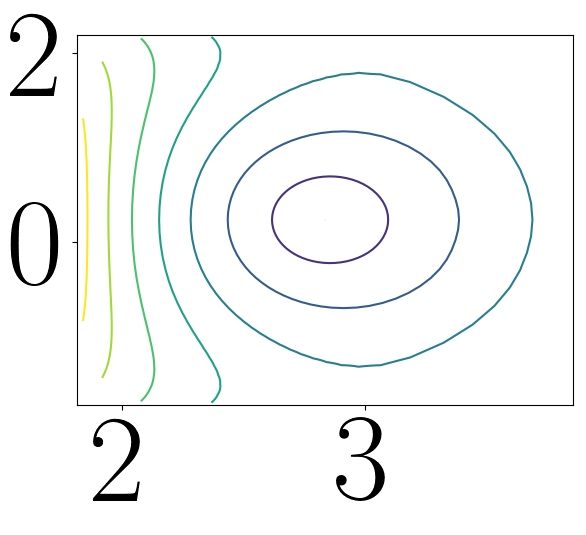

In [168]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B3[:,:,1])
PyPlot.show()

## Integration and Poincare Plot

In [106]:
function Field_line_df!(du,u,p,t)
    du[1] = B1_df(u[1],u[2],u[3])
    du[2] = B2_df(u[1],u[2],u[3])
    du[3] = B3_df(u[1],u[2],u[3])
end

function condition_cross(u,t,integrator)
    u[3] - integrator.p[1]*2.0*pi
end
function count_cross!(integrator)
    integrator.p[1] = integrator.p[1] + 1
end

cb1 = ContinuousCallback(condition_cross,count_cross!,rootfind = true,save_positions=(false,true))

function field_line_integration_df(rs::Float64,us::Float64)
    u0 = [rs,us,0.0]
    p = [1]
    tspan = (0.0,10080.0)
    prob = ODEProblem(Field_line_df!,u0,tspan,p)
    sol = solve(prob,BS5(),callback = cb1,reltol=1.e-8,abstol=1.e-10,save_everystep=false,save_start=false,save_end=false)
    #sol = solve(prob,BS5(),callback = cb1,reltol=1.e-8,abstol=1.e-10)
    return sol
end

field_line_integration_df (generic function with 1 method)

In [17]:
soldf = field_line_integration_df(0.189,0.0);

In [18]:
xsdf = [X_eint(soldf[1,i],soldf[2,i],0) for i in 1:length(soldf.t)];
ysdf = [Y_eint(soldf[1,i],soldf[2,i],0) for i in 1:length(soldf.t)];
zsdf = [Z_eint(soldf[1,i],soldf[2,i],0) for i in 1:length(soldf.t)];

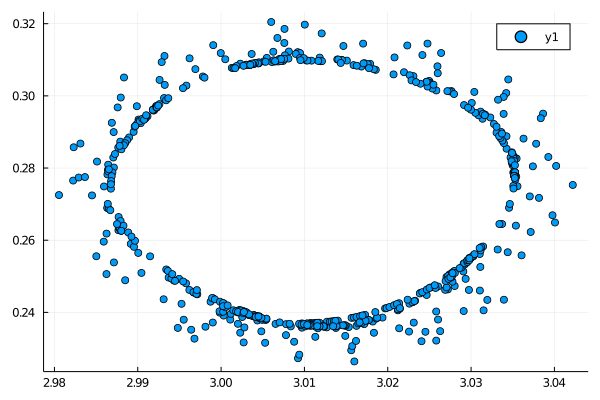

In [19]:
Plots.scatter(xsdf,zsdf)

In [20]:
function Poincare_Map(Nr::Int,Np::Int)
    icr = LinRange(0.2,0.9,Nr)
    icu = LinRange(0.0,2*pi,Np)
    ic_tot = Nr*Np
    r = [[] for i in 1:ic_tot]
    theta = [[] for i in 1:ic_tot]
    phi = [[] for i in 1:ic_tot]
    for i in 1:Nr
        for j in 1:Np
            sol = field_line_integration_df(icr[i],icu[j])
            r[i*j] = sol[1,:]
            theta[i*j] = sol[2,:]
            phi[i*j] = sol[3,:]
        end
    end
    xx = [[] for i in 1:ic_tot]
    zz = [[] for i in 1:ic_tot]
    for i in 1:ic_tot
        xcoord = [X_eint(r[i][j],theta[i][j],0) for j in 1:length(r[i])]
        zcoord = [Z_eint(r[i][j],theta[i][j],0) for j in 1:length(r[i])]
        xx[i] = xcoord
        zz[i] = zcoord
    end
    return xx,zz
end

Poincare_Map (generic function with 1 method)

In [21]:
xxp,zzp = Poincare_Map(3,3);

In [22]:
shape = pyimport("poinc")

PyObject <module 'poinc' from '/users/giannis_kx/nemato_config/poinc.py'>

In [24]:
Rs,Zs = shape.shaping_plot();

In [25]:
shape.eqdsk_info()

In [26]:
pyimport("importlib")."reload"(shape)

PyObject <module 'poinc' from '/users/giannis_kx/nemato_config/poinc.py'>

In [60]:
pyimport("importlib")."reload"(pxr)

PyObject <module 'pixie_read_st' from '/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [27]:
gr(size=(1000,1000), html_output_format=:png)

Plots.GRBackend()

In [28]:
x_r = maximum(shape.m.DS.rlim) + 0.1;
x_l = minimum(shape.m.DS.rlim) - 0.1;
z_u = maximum(shape.m.DS.zlim) + 0.1;
z_d = minimum(shape.m.DS.zlim) - 0.1;

In [89]:
Plots.plot();

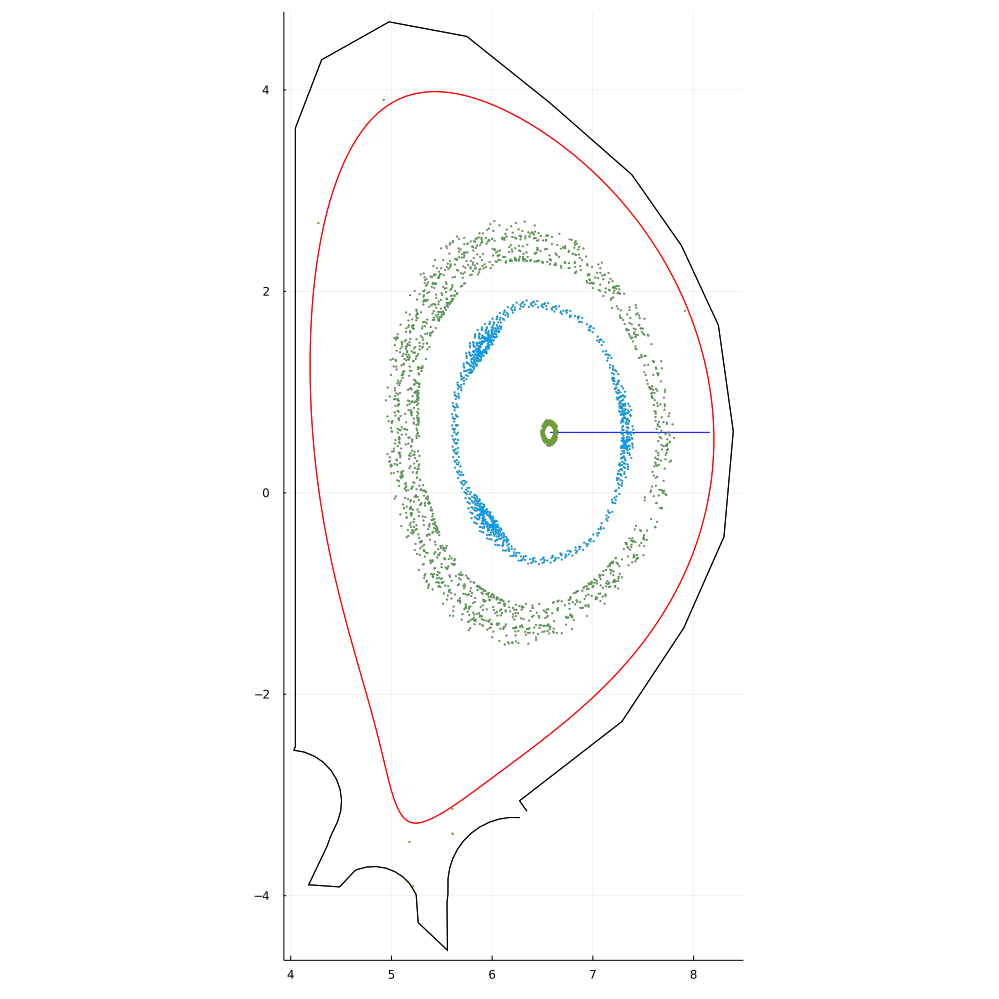

In [110]:
Plots.plot!(shape.m.DS.rlim,shape.m.DS.zlim,linecolor =:black);
Plots.plot!(shape.m.DS.rbbbs,shape.m.DS.zbbbs,linecolor=:red);
Plots.plot!(X_eint(r_of_psi_array[1],0,0).*shape.e.a,0.6.*ones(101),linecolor=:blue)
#Plots.plot!(Rs,Zs);
for i in 1:9
    Plots.scatter!(xxp[i]*shape.e.a,zzp[i]*shape.e.a,markerstrokewidth=0,markersize=1.2,legend=false,aspect_ratio=:equal,xlims=(x_l,x_r),ylims=(z_d,z_u));
end
current()

## Print formatting

In [ ]:
using Printf

In [ ]:
tmst = 100;
@printf("New timestep %s",(tmst))

In [ ]:
PL = current();

In [ ]:
savestring = @sprintf("PP@%s.png",(tmst))

In [ ]:
typeof(savestring)

In [ ]:
savefig(PL,savestring)

## Plot with $\psi$ labels

In [31]:
using Dierckx

In [32]:
psi_list = LinRange(0,1,101);

In [63]:
r_of_psi_array[1];

In [64]:
r2p = Spline1D(r_of_psi_array[1],psi_list,bc="zero") # psi(r)

Spline1D(knots=[0.171875,0.296171 … 0.878953,0.887268] (99 elements), k=3, extrapolation="zero", residual=0.0)

In [65]:
p2r = Spline1D(psi_list,r_of_psi_array[1],bc="zero") # r(psi)

Spline1D(knots=[0.0,0.02 … 0.98,1.0] (99 elements), k=3, extrapolation="zero", residual=0.0)

In [66]:
R_list = [pxr.X[i,1,1] for i in 1:size(pxr.X)[1]];

In [67]:
r_list = [i/(size(pxr.X)[1]-1) for i in 0:size(pxr.X)[1]-1];

In [68]:
R2r = Spline1D(R_list,r_list,bc="zero") # r(R)

Spline1D(knots=[2.83804,2.85399 … 3.84117,3.85702] (127 elements), k=3, extrapolation="zero", residual=0.0)

In [69]:
r2R = Spline1D(r_list,R_list,bc="zero") # R(r)

Spline1D(knots=[0.0,0.015625 … 0.984375,1.0] (127 elements), k=3, extrapolation="zero", residual=0.0)

In [70]:
R2r(3.2)

0.35461502384099464

In [71]:
r2p(R2r(3.2))

0.04890600419080609

In [ ]:
rmaxis

In [126]:
psi_labels=[0.0,0.025,0.1,0.3,0.6,0.8,1.0];

In [127]:
x_tick_pos = r2R(p2r(psi_labels))

7-element Array{Float64,1}:
 3.0135017594483076
 3.152572481910892
 3.268023193786437
 3.4182415614714237
 3.5681130255876616
 3.6569675025413635
 3.742578449346311

In [130]:
x_tick_lab = [string(x) for x in psi_labels]

7-element Array{String,1}:
 "0.0"
 "0.025"
 "0.1"
 "0.3"
 "0.6"
 "0.8"
 "1.0"

In [140]:
Plots.plot();

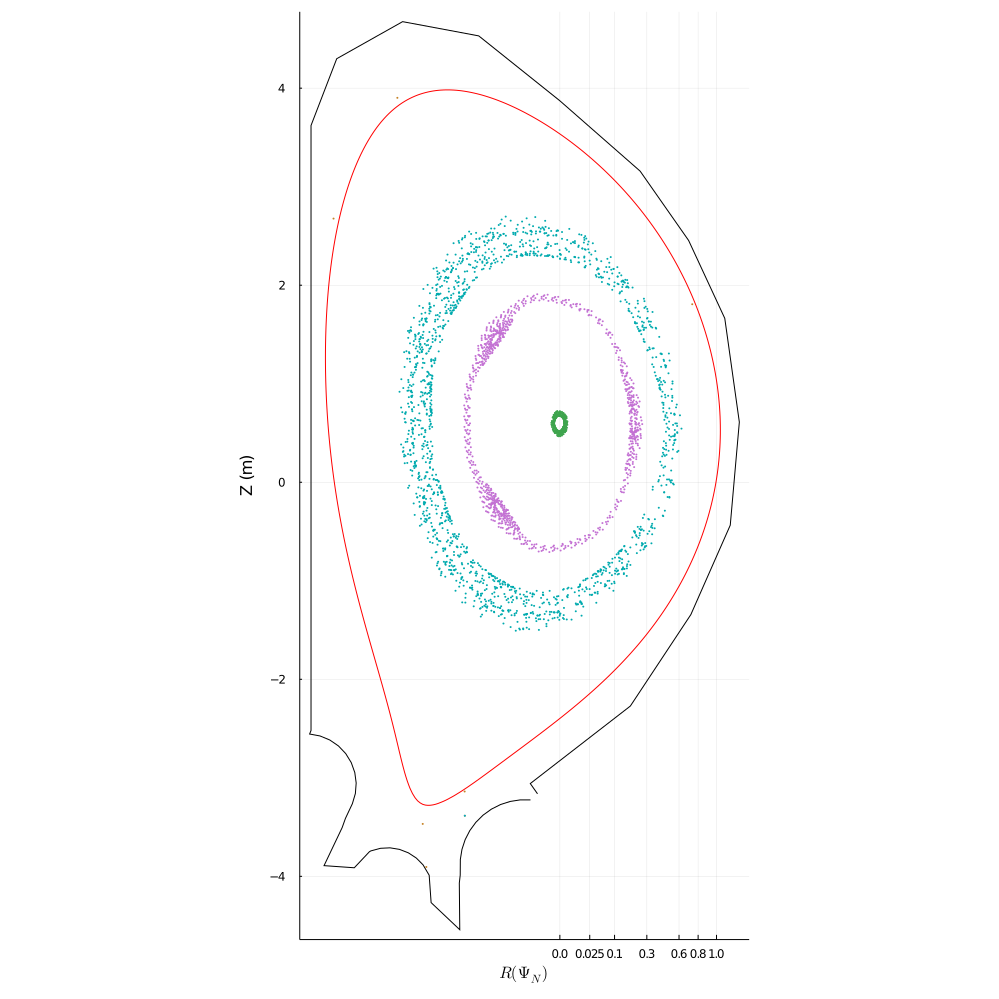

In [141]:
Plots.plot!(shape.m.DS.rlim,shape.m.DS.zlim,linecolor = :black);
Plots.plot!(shape.m.DS.rbbbs,shape.m.DS.zbbbs,linecolor=:red);
#Plots.plot!(Rs,Zs);
for i in 1:9
    Plots.scatter!(xxp[i]*shape.e.a,zzp[i]*shape.e.a,markerstrokewidth=0,markersize=1.2,legend=false,aspect_ratio=:equal,xlims=(x_l,x_r),ylims=(z_d,z_u));
end
old_xticks = xticks(plt1[1]);
#xticks!(old_xticks[1],["one","two","three","four","five"])
xticks!(x_tick_pos*shape.e.a,x_tick_lab)
xlabel!(L"R (\Psi_N)")
ylabel!("Z (m)")
current()

## Zero modes

In [169]:
using FFTW

In [173]:
B10 = dropdims(mean(B1,dims=3),dims=3);

In [175]:
na = [CartesianIndex()];

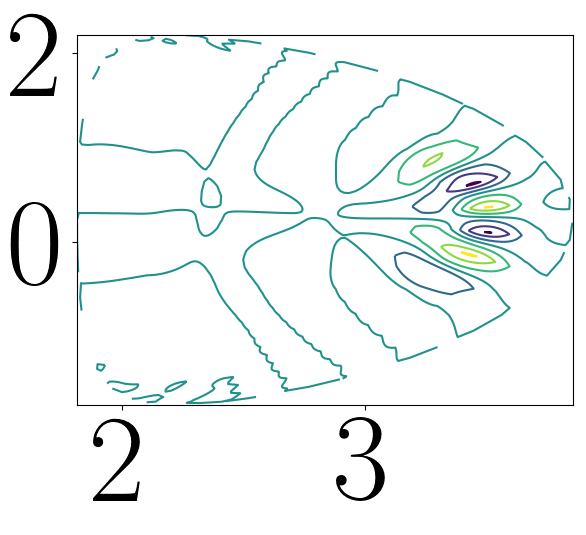

In [177]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],B1[:,:,1].-B10[:,:])
PyPlot.show()

In [178]:
B1fft = fft(B1,[2,3]);

In [179]:
db = B1.-B10[:,:,na];

In [181]:
dbfft = fft(db,[2,3]);

In [184]:
B1fft[30,2,2]

0.0012298343863422986 - 0.011086864045294067im

In [187]:
dbfft[30,33,1]

3.871008331587933e-16 - 7.102638078105693e-16im

In [189]:
idb = ifft(dbfft,[2,3]);

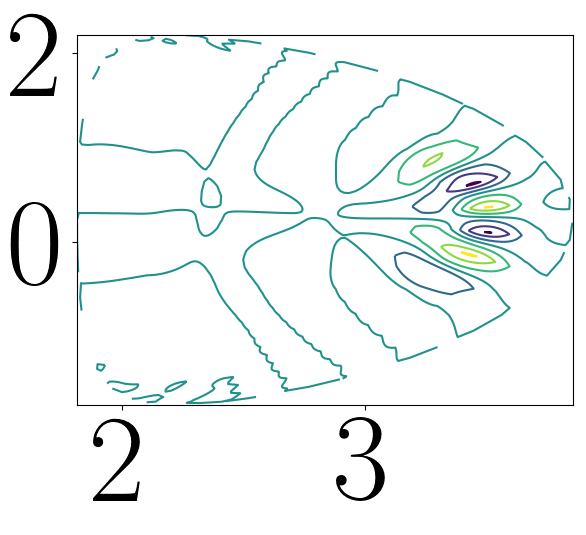

In [191]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],idb[:,:,1])
PyPlot.show()

In [192]:
iB1 = ifft(B1fft,[2,3]);

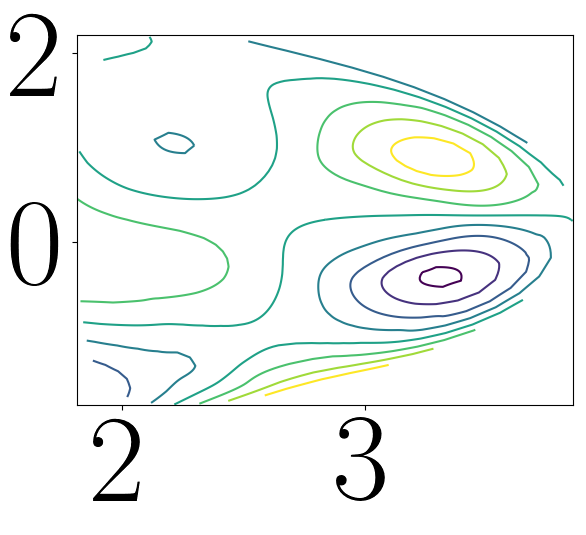

In [193]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],iB1[:,:,1])
PyPlot.show()

In [194]:
zfftB1 = deepcopy(B1fft);

In [196]:
zfftB1[:,:,1] .= 0;

In [197]:
izB1 = ifft(zfftB1,[2,3]);

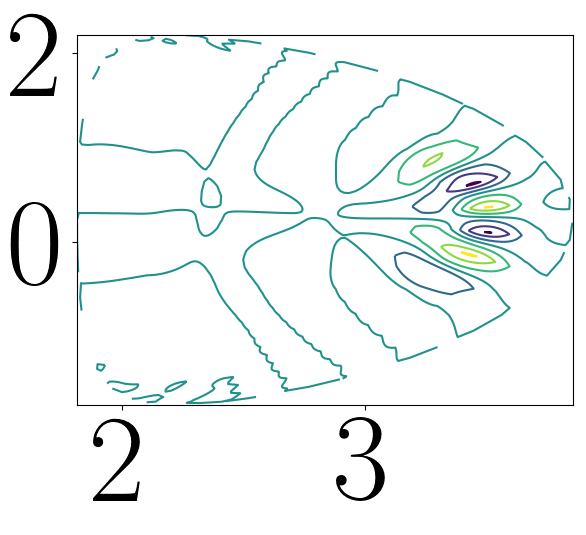

In [198]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],izB1[:,:,1])
PyPlot.show()